### Setup

In [5]:
import hydrangea as hy
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sim = hy.Simulation(0)
print(sim.run_dir)

/net/quasar/data3/Hydrangea/10r200/CE-0/HYDRO/


In [4]:
bh_mergers = sim.run_dir + 'data/black_hole_log_files/mergers.hdf5'
bh_details = sim.run_dir + 'data/black_hole_log_files/details.hdf5'

### Black hole mergers

For simplicity, load all HDF5 data sets into a python dict.

In [6]:
mergers = {"Mass1": hy.hdf5.read_data(bh_mergers, "BlackHoles/Mergers/Merger_Mass1"),
           "Mass2": hy.hdf5.read_data(bh_mergers, "BlackHoles/Mergers/Merger_Mass2"),
           "ID1": hy.hdf5.read_data(bh_mergers, "BlackHoles/Mergers/Merger_Particle_ID1"),
           "ID2": hy.hdf5.read_data(bh_mergers, "BlackHoles/Mergers/Merger_Particle_ID2"),
           "Time": hy.hdf5.read_data(bh_mergers, "BlackHoles/Mergers/Merger_Time")}

ID1 refers to the *surviving* BH particle, ID2 to the one that *got swallowed*

In [55]:
print(mergers["ID1"][0])  # Find the first swallowing BH in the list

264036987


Each BH can swallow multiple others, but can only be swallowed at most once.

In [19]:
print(np.nonzero(mergers["ID1"] == 264036987))
print(np.nonzero(mergers["ID2"] == 264036987))

(array([   0,    1,    2,    3,  893, 1781]),)
(array([0]),)


Let's look at the masses of the BHs that this one swallowed, and when:

In [35]:
ind_swallow = np.nonzero(mergers["ID1"] == 264036987)[0]
print(np.log10(mergers["Mass1"][ind_swallow] * 1e10 / 0.6777)) # Convert to M_Sun 
print(np.log10(mergers["Mass2"][ind_swallow] * 1e10 / 0.6777))
print(mergers["Time"][ind_swallow])

[5.2338734 5.755587  6.306063  7.628411  7.6794605 7.9303994]
[5.2613816 5.2106314 5.20846   5.171509  5.1751933 5.1726513]
[0.173943 0.177271 0.181736 0.194201 0.195123 0.233203]


In this case, we were lucky: all the "victims" were less massive than the swallowing BH. This is not too unexpected: most BHs never grow much above their seed mass, so that a massive BH is much more likely to merge with a lower mass one.

Now, let's look at the merger that "deleted" this BH:

In [38]:
ind_swallowed = np.nonzero(mergers["ID2"] == 264036987)[0][0]     # Second [0] to look at specific entry in array
print(np.log10(mergers["Mass1"][ind_swallowed] * 1e10 / 0.6777))
print(np.log10(mergers["Mass2"][ind_swallowed] * 1e10 / 0.6777))
print(mergers["ID1"][ind_swallowed])

5.169635161165328
8.099419942369748
350643715


So this was a "false" merger: the surviving BH had a much lower mass. To keep tracking the BH that has vanished, we would now need to follow ID 350643715. Let's see how this continues:

In [23]:
IDs = [264036987]   # Start with the one it has to begin with, could also choose at z = 0.
t_switch = [0]
while(True):
    curr_ID = IDs[-1]
    ind_next = np.nonzero((mergers["ID2"] == curr_ID) &
                          (mergers["Mass2"] > mergers["Mass1"]))[0]
    
    # If the BH does not get falsely swallowed anymore, we can stop
    if len(ind_next) == 0:
        break

    IDs.append(mergers["ID1"][ind_next[0]])
    t_switch.append(mergers["Time"][ind_next[0]])
        
t_switch.append(1)
print(f"The BH takes {len(IDs)} different IDs: {IDs}")
print(f"Switches occur at {t_switch}.")

The BH takes 5 different IDs: [264036987, 350643715, 350645461, 360772955, 363058985]
Switches occur at [0, 0.282977, 0.288669, 0.576387, 0.687549, 1].


In [14]:
mergers["Time"][ind_next]

array([0.282977], dtype=float32)

### Black hole details

In [16]:
details = {"Mass": hy.hdf5.read_data(bh_details, "BlackHoles/Mass_Subgrid"),
           "Mdot": hy.hdf5.read_data(bh_details, "BlackHoles/Mdot"),
           "Time": hy.hdf5.read_data(bh_details, "BlackHoles/Time"),
           "ID": hy.hdf5.read_data(bh_details, "BlackHoles/Particle_ID")}

In [43]:
xxx = np.nonzero(details["ID"] == 264036987)[0]
print(f'There are {len(xxx)} recorded steps for BH ID 264036987.')
print(np.min(details["Time"][xxx]), np.max(details["Time"][xxx]))

There are 2930 recorded steps for BH ID 264036987.
0.0936706 0.282977


In [46]:
plt.plot(details['Time'][xxx], details['Mdot'][xxx])

In [45]:
xxx

array([30147917, 30147918, 30147919, ..., 30150844, 30150845, 30150846])

Plot the mass growth history of the BH, using all the IDs we found earlier

In [54]:
ax = plt.gca()
colors = ['red', 'gold', 'green', 'royalblue', 'purple']
for iiid, iid in enumerate(IDs):
    xxx = np.nonzero(details["ID"] == iid)[0]
    plt.plot(details["Time"][xxx], np.log10(details["Mass"][xxx] * 1e10 / 0.6777), color=colors[iiid])
ax.set_xlabel('Expansion factor')
ax.set_ylabel(r'log$_{10} (M_\mathrm{BH}\,/\,\mathrm{M}_\odot)$')

Text(0, 0.5, 'log$_{10} (M_\\mathrm{BH}\\,/\\,\\mathrm{M}_\\odot)$')

The "real" growth track of the BH is given by the line at the top. Every time there is another ("false")
merger, the colour changes as the BH effectively gets a new ID.

### Find the continuous history of the most massive BH progenitor

In [34]:
t = np.zeros(0)
m = np.zeros(0)
mdot = np.zeros(0)
for ii, bh_id in enumerate(IDs):
    xxx = np.nonzero((details["ID"] == bh_id) &
                     (details["Time"] > t_switch[ii]) & (details["Time"] <= t_switch[ii+1]))[0]
    t = np.concatenate((t, details["Time"][xxx]))
    m = np.concatenate((m, details["Mass"][xxx]))
    mdot = np.concatenate((mdot, details["Mdot"][xxx]))

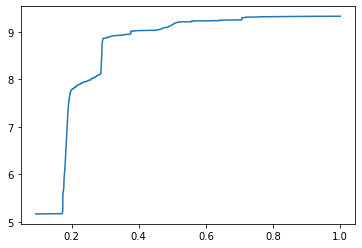

In [47]:
plt.plot(t, np.log10(m/0.6777)+10)

(0.25, 0.3)

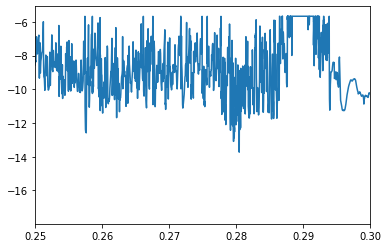

In [42]:
ax = plt.gca()
plt.plot(t, np.log10(mdot/(m*1e10/0.6777)))
ax.set_xlim((0.25, 0.3))


In [38]:
mdot

array([8.30124991e-05, 1.02705999e-04, 1.98440001e-04, ...,
       3.78811004e-04, 3.83590988e-04, 4.11548011e-04])